**Problem 1**

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from scipy.optimize import minimize


In [47]:
def rosenbrock (x):
    """The Rosenbrock function (n-dimensional)."""
    # sum of 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(n-1)
    return sum(100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))

def finite_difference_jacobian(func, x, epsilon=1e-8):
    """Compute the Jacobian of a function using finite differences."""
    n = len(x)
    jacobian = np.zeros(n)
    
    f_x = func(x)
    
    for i in range(n):
        x_plus = np.copy(x)
        x_plus[i] += epsilon
        f_x_plus_h = func(x_plus)
        
        jacobian[i] = (f_x_plus_h - f_x) / epsilon
    return jacobian

def complex_step_jacobian(func, x, epsilon=1e-20):
    """Compute the Jacobian of a function using the complex step method."""
    n = len(x)
    jacobian = np.zeros(n)
    
    for i in range(n):
        x_complex = np.copy(x).astype(complex)
        x_complex[i] += 1j * epsilon
        f_x_complex = func(x_complex)
        
        jacobian[i] = np.imag(f_x_complex) / epsilon
    return jacobian

quick check

In [48]:
x0 = np.array([-1.2, 1.0])

print("Point x0:", x0)

# 1. finite difference
grad_fd = finite_difference_jacobian(rosenbrock, x0, epsilon=1e-8)
print("Gradient (finite difference):", grad_fd)

# 2. complex step
grad_cs = complex_step_jacobian(rosenbrock, x0, epsilon=1e-20)
print("Gradient (complex step):", grad_cs)

# analytical gradient
def grad_rosenbrock(x):
    # df/dx1 = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    # df/dx2 = 200*(x[1]-x[0]**2)
    n = len(x)
    grad = np.zeros(n)
    
    # first component
    grad[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    # middle components (if n > 2)
    for i in range(1, n-1):
        grad[i] = 200 * (x[i] - x[i-1]**2) - 400 * x[i] * (x[i+1] - x[i]**2) - 2 * (1 - x[i])
        
    # last component
    grad[-1] = 200 * (x[-1] - x[-2]**2)
    
    return grad
    
print("Exact gradient:", grad_rosenbrock(x0))

Point x0: [-1.2  1. ]
Gradient (finite difference): [-215.59999226  -87.99999875]
Gradient (complex step): [-215.6  -88. ]
Exact gradient: [-215.6  -88. ]


4.1 answers

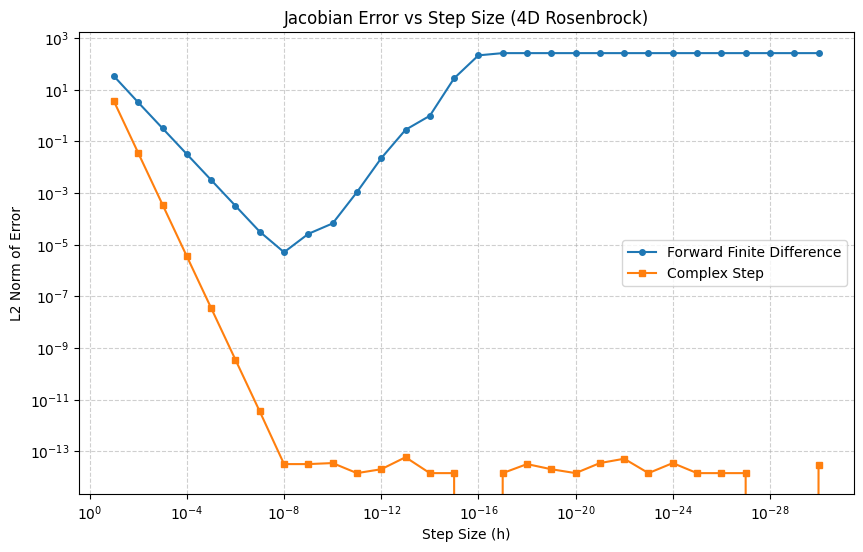

In [49]:
x0 = np.array([0.5, -0.5, 0.5, 1.0])
exact_grad = grad_rosenbrock(x0)
# print("Exact Gradient at x0:", exact_grad)
# print("Exact Grad Shape:", exact_grad.shape)


# Create epsilon values (10^-1, 10^-2, ..., 10^-30)
epsilons = 10.0 ** np.arange(-1, -31, -1)

fd_errors = []
cs_errors = []

for epsilon in epsilons:
    grad_fd = finite_difference_jacobian(rosenbrock, x0, epsilon)
    # print("FD Shape:", grad_fd.shape)
    grad_cs = complex_step_jacobian(rosenbrock, x0, epsilon)
    # print("CS Shape:", grad_cs.shape)

    fd_error = np.linalg.norm(grad_fd - exact_grad)
    cs_error = np.linalg.norm(grad_cs - exact_grad)
    
    fd_errors.append(fd_error)
    cs_errors.append(cs_error)
    
# Plotting the errors
plt.figure(figsize=(10, 6))
plt.loglog(epsilons, fd_errors, 'o-', label='Forward Finite Difference', markersize=4)
plt.loglog(epsilons, cs_errors, 's-', label='Complex Step', markersize=4)

# Formatting the plot
plt.xlabel('Step Size (h)')
plt.ylabel('L2 Norm of Error')
plt.title('Jacobian Error vs Step Size (4D Rosenbrock)')

# Invert X axis so h decreases to the right (common in numerical methods textbooks like Fig 6.9)
plt.gca().invert_xaxis()  

plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

**Problem 2**

In [50]:
'''
a = x**2 + 3*y**2
b = sin(a)
c = 3*x**2 + y**2
d = sin(c)
e = x**2 + y**2
g = -0.5*exp(-e/2)
f1 = a + c + g
h = x*y
f2 = a - g + h
'''

def vector_functions(vars):
    x, y = vars
    a = x**2 + 3*y**2
    b = np.sin(a)
    c = 3*x**2 + y**2
    d = np.sin(c)
    e = x**2 + y**2
    g = -0.5 * np.exp(-e/2)
    
    f1 = a + c + g
    h = x * y
    f2 = a - g + h
    
    return np.array([f1, f2])

def complex_step_jacobian(func, vars, epsilon=1e-20):
    f0 = func(vars)
    n = len(vars)
    m = len(f0) 
    
    jacobian = np.zeros((m, n))
    
    for i in range(n):
        vars_complex = np.copy(vars).astype(complex)
        vars_complex[i] += 1j * epsilon
        f_complex = func(vars_complex)
        
        jacobian[:, i] = np.imag(f_complex) / epsilon
    return jacobian

point = np.array([2.0, 1.5])
J = complex_step_jacobian(vector_functions, point)

print("Jacobian at point", point)
print(J)

Jacobian at point [2.  1.5]
[[16.04393693 12.0329527 ]
 [ 5.45606307 10.9670473 ]]


**Problem 3**

In [ ]:
from jax.numpy import sin, cos, pi, sqrt

def differentiable_truss(A):
    # Determine the data type to prevent casting errors
    # This captures if A is float32, float64, or complex
    dtype = A.dtype 

    # --- Truss Setup (from your code and PDF) ---
    P = 1e5  
    Ls = 360.0  
    Ld = jnp.sqrt(360.0**2 * 2.0)  

    start = jnp.array([5, 3, 6, 4, 4, 2, 5, 6, 3, 4])
    finish = jnp.array([3, 1, 4, 2, 3, 1, 4, 3, 2, 1])
    phi = jnp.array([0, 0, 0, 0, 90, 90, -45, 45, -45, 45]) * pi / 180
    L = jnp.array([Ls, Ls, Ls, Ls, Ls, Ls, Ld, Ld, Ld, Ld])

    E = 1e7 * jnp.ones(10)  
    rho = 0.1 * jnp.ones(10)  
    
    n_nodes = 6
    DOF = 2

    # Mass Calculation
    mass = jnp.sum(rho * A * L)

    # Initialize matrices with the correct dtype!
    K = jnp.zeros((DOF * n_nodes, DOF * n_nodes), dtype=dtype)
    S_global = jnp.zeros((10, DOF * n_nodes), dtype=dtype)

    for i in range(10):
        c, s = cos(phi[i]), sin(phi[i])
        k_local = (E[i] * A[i] / L[i]) * jnp.array([
            [c**2, c*s, -c**2, -c*s],
            [c*s, s**2, -c*s, -s**2],
            [-c**2, -c*s, c**2, c*s],
            [-c*s, -s**2, c*s, s**2]
        ], dtype=dtype) # Ensure submatrix is also correct dtype
        s_local = (E[i] / L[i]) * jnp.array([-c, -s, c, s], dtype=dtype)

        n1, n2 = start[i], finish[i]
        idx = jnp.array([2*n1-2, 2*n1-1, 2*n2-2, 2*n2-1])
        
        K = K.at[jnp.ix_(idx, idx)].add(k_local)
        S_global = S_global.at[i, idx].set(s_local)

    F = jnp.zeros(n_nodes * DOF, dtype=dtype)
    F = F.at[3].set(-P) 
    F = F.at[7].set(-P) 

    keep = jnp.array([0, 1, 2, 3, 4, 5, 6, 7])
    K_red = K[jnp.ix_(keep, keep)]
    F_red = F[keep]
    S_red = S_global[:, keep]

    d_red = jnp.linalg.solve(K_red, F_red)
    stress = jnp.dot(S_red, d_red)

    return mass, stress

def find_mass(A):
    m, _ = differentiable_truss(A)
    return m

def find_stress(A):
    _, s = differentiable_truss(A)
    return s

# A. forward finite difference
def fd_jacobian(func, x, args=(), epsilon=1e-8):
    f0 = func(x, *args)
    m = 1 if jnp.isscalar(f0) else len(f0)
    n = len(x)
    
    jacob = np.zeros((m, n)) 
    
    for i in range(n):
        x_plus = np.copy(x)
        x_plus[i] += epsilon
        f_plus = func(x_plus, *args)
        
        if m == 1:
            jacob[0, i] = (f_plus - f0) / epsilon
        else:
            jacob[:, i] = (f_plus - f0) / epsilon
            
    return jnp.array(jacob.squeeze()) # Return as jnp array 

# B. complex step
def complex_step_jacobian(func, x, args=(), epsilon=1e-20):
    f0 = func(x, *args)
    m = 1 if jnp.isscalar(f0) else len(f0)
    n = len(x)
    
    jacob = np.zeros((m, n)) 
    
    for i in range(n):
        x_plus = np.array(x, dtype=complex)
        x_plus[i] += complex(0, epsilon)
        f_plus = func(x_plus, *args)
        
        if m == 1:
            jacob[0, i] = np.imag(f_plus) / epsilon
        else:
            jacob[:, i] = np.imag(f_plus) / epsilon
            
    return jnp.array(jacob.squeeze())

# initial points
A0 = jnp.ones(10) * 1.0

# --- MASS DERIVATIVE ---
dm_dA_fd = fd_jacobian(find_mass, A0, epsilon=1e-8)
dm_dA_cs = complex_step_jacobian(find_mass, A0, epsilon=1e-20)
dm_dA_ad = jax.grad(find_mass)(A0)

print("--- Mass Derivatives (dm/dA) ---")
print(f"FD vs AD Error: {jnp.linalg.norm(dm_dA_fd - dm_dA_ad):.2e}")
print(f"CS vs AD Error: {jnp.linalg.norm(dm_dA_cs - dm_dA_ad):.2e}")

# --- STRESS DERIVATIVE ---
dsig_dA_fd = fd_jacobian(find_stress, A0, epsilon=1e-8)
dsig_dA_cs = complex_step_jacobian(find_stress, A0, epsilon=1e-20)
dsig_dA_ad = jax.jacfwd(find_stress)(A0)

print("\n--- Stress Jacobian (dsig/dA) ---")
print(f"FD vs AD Error: {jnp.linalg.norm(dsig_dA_fd - dsig_dA_ad):.2e}")
print(f"CS vs AD Error: {jnp.linalg.norm(dsig_dA_cs - dsig_dA_ad):.2e}")

--- Mass Derivatives (dm/dA) ---
FD vs AD Error: 1.03e-06
CS vs AD Error: 1.42e-14

--- Stress Jacobian (dsig/dA) ---
FD vs AD Error: 1.14e-01
CS vs AD Error: 3.85e-10


**Problem 4**

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1593.1809091054417
            Iterations: 15
            Function evaluations: 22
            Gradient evaluations: 11


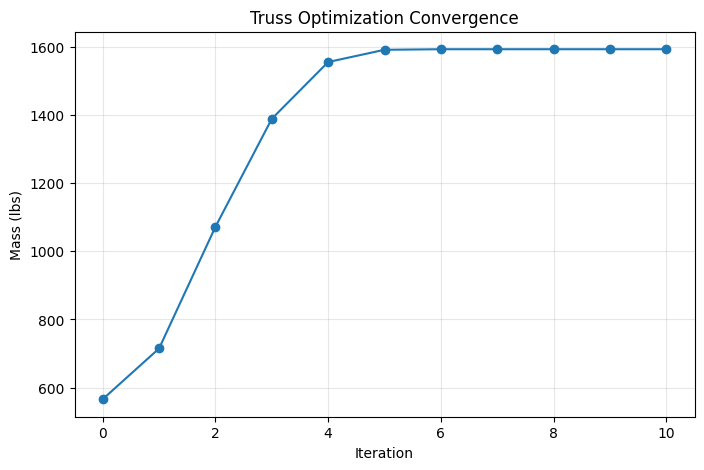

Final Mass: 1593.1809 lbs
Function Calls: 33
Max Stress: 25000.000000331926
Min Area: 0.1


In [ ]:
func_calls = 0

def objective(A):
    global func_calls
    func_calls += 1
    return float(find_mass(A))  

def obj_grad(A):
    return np.array(jax.grad(find_mass)(A))

def stress_contstraint(A):
    stresses = find_stress(A)
    
    val = 25000.0 - jnp.abs(stresses)  
    return np.array(val)

def stress_jacob(A):
    stresses = find_stress(A)
    jacob = jax.jacfwd(find_stress)(A)
    
    grad = -jnp.sign(stresses)[:, None] * jacob  #
    return np.array(grad)

history = []

def callback(xk):
    history.append(objective(xk))
    
# optimization
A0 = jnp.ones(10) * 1.0
bounds = [(0.1, None)] * 10
cons = {'type': 'ineq', 'fun': stress_contstraint, 'jac': stress_jacob}

res = minimize(objective, A0, method='SLSQP', jac=obj_grad, 
               constraints=cons, bounds=bounds, callback=callback,
               options={'ftol': 1e-9, 'disp': True})

# convergence plots
plt.figure(figsize=(8, 5))
plt.plot(history, 'o-')
plt.xlabel('Iteration')
plt.ylabel('Mass (lbs)')
plt.title('Truss Optimization Convergence')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Mass: {res.fun:.4f} lbs")
print(f"Function Calls: {func_calls}")

final_stresses = find_stress(res.x)
print("Max Stress:", jnp.max(jnp.abs(final_stresses)))
print("Min Area:", jnp.min(res.x))

In [ ]:
final_areas = res.x
final_stresses = find_stress(final_areas)

Ls = 360.0  
Ld = jnp.sqrt(360.0**2 * 2.0)  
lengths = jnp.array([Ls, Ls, Ls, Ls, Ls, Ls, Ld, Ld, Ld, Ld])
rho = 0.1

print(f"{'Member':<8} | {'Area (in^2)':<12} | {'Length (in)':<12} | {'Mass (lbs)':<10} | {'Stress (psi)':<12}")
print("-" * 65)

for i in range(10):
    area = final_areas[i]
    length = lengths[i]
    mass = rho * area * length
    stress = final_stresses[i]
    
    print(f"{i+1:<8} | {area:<12.4f} | {length:<12.2f} | {mass:<10.2f} | {stress:<12.2f}")

print("-" * 65)
print(f"{'TOTAL':<8} | {'':<12} | {'':<12} | {res.fun:<10.2f} |")

Member   | Area (in^2)  | Length (in)  | Mass (lbs) | Stress (psi)
-----------------------------------------------------------------
1        | 7.9379       | 360.00       | 285.76     | 25000.00    
2        | 0.1000       | 360.00       | 3.60       | 15533.01    
3        | 8.0621       | 360.00       | 290.24     | -25000.00   
4        | 3.9379       | 360.00       | 141.76     | -25000.00   
5        | 0.1000       | 360.00       | 3.60       | -0.00       
6        | 0.1000       | 360.00       | 3.60       | 15533.01    
7        | 5.7447       | 509.12       | 292.47     | 25000.00    
8        | 5.5690       | 509.12       | 283.53     | -25000.00   
9        | 5.5690       | 509.12       | 283.53     | 25000.00    
10       | 0.1000       | 509.12       | 5.09       | -21966.99   
-----------------------------------------------------------------
TOTAL    |              |              | 1593.18    |
